In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [4]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('using PyTorch version::', torch.__version__, 'Device:', DEVICE)


using PyTorch version:: 2.0.0+cpu Device: cpu


In [5]:
BATCH_SIZE =32
EPOCHS =10

In [8]:
train_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashoinMNIST",
                                     download=True,
                                     train =False,
                                     transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle =True)
test_loader=torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = BATCH_SIZE,
                                        shuffle = False)



100%|██████████| 26421880/26421880 [01:18<00:00, 338621.25it/s]


Extracting ../data/FashoinMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data/FashoinMNIST\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 90846.49it/s]


Extracting ../data/FashoinMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data/FashoinMNIST\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:07<00:00, 600711.94it/s]


Extracting ../data/FashoinMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data/FashoinMNIST\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5094921.42it/s]

Extracting ../data/FashoinMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/FashoinMNIST\FashionMNIST\raw



In [9]:
for(X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('Y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
Y_train: torch.Size([32]) type: torch.LongTensor


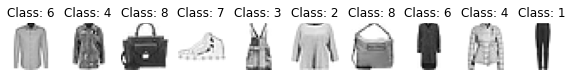

In [11]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [17]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),)
        
        self.decoder =nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [18]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [24]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [20]:
def evaluate(model, test_loader):
    model.eval()
    test_loss =0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(DEVICE)
            target = image.view(-1, 28*28).to(DEVICE)
            encoded, decoded= model(image)

            test_loss += criterion(decoded, image).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))


    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.186276
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.029431
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.023758
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.023852
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.021398
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.019888
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.016691
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.019156
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.015151
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.015507

[EPOCH: 1], 	Test Loss: 0.0005


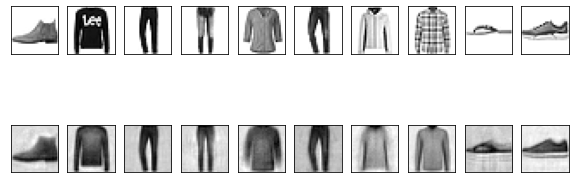

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.013858
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.016574
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.015380
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.015065
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.015821
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.013419
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.014129
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.014663
Train Epoch: 2 [51200/60000 (85%)]	Train Loss: 0.013712
Train Epoch: 2 [57600/60000 (96%)]	Train Loss: 0.014463

[EPOCH: 2], 	Test Loss: 0.0004


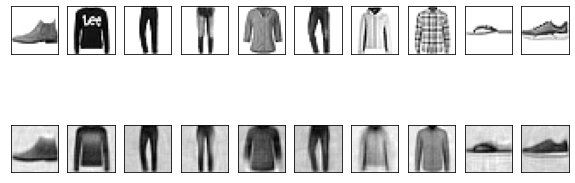

Train Epoch: 3 [0/60000 (0%)]	Train Loss: 0.014308
Train Epoch: 3 [6400/60000 (11%)]	Train Loss: 0.013064
Train Epoch: 3 [12800/60000 (21%)]	Train Loss: 0.013570
Train Epoch: 3 [19200/60000 (32%)]	Train Loss: 0.011885
Train Epoch: 3 [25600/60000 (43%)]	Train Loss: 0.011180
Train Epoch: 3 [32000/60000 (53%)]	Train Loss: 0.010252
Train Epoch: 3 [38400/60000 (64%)]	Train Loss: 0.010156
Train Epoch: 3 [44800/60000 (75%)]	Train Loss: 0.013880
Train Epoch: 3 [51200/60000 (85%)]	Train Loss: 0.012214
Train Epoch: 3 [57600/60000 (96%)]	Train Loss: 0.012144

[EPOCH: 3], 	Test Loss: 0.0004


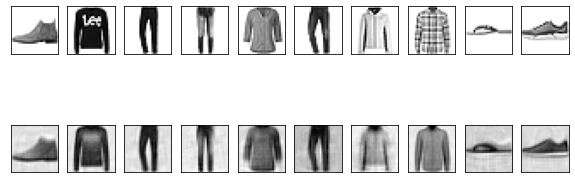

Train Epoch: 4 [0/60000 (0%)]	Train Loss: 0.010317
Train Epoch: 4 [6400/60000 (11%)]	Train Loss: 0.014971
Train Epoch: 4 [12800/60000 (21%)]	Train Loss: 0.010508
Train Epoch: 4 [19200/60000 (32%)]	Train Loss: 0.008688
Train Epoch: 4 [25600/60000 (43%)]	Train Loss: 0.012253
Train Epoch: 4 [32000/60000 (53%)]	Train Loss: 0.014090
Train Epoch: 4 [38400/60000 (64%)]	Train Loss: 0.010700
Train Epoch: 4 [44800/60000 (75%)]	Train Loss: 0.011817
Train Epoch: 4 [51200/60000 (85%)]	Train Loss: 0.009753
Train Epoch: 4 [57600/60000 (96%)]	Train Loss: 0.012618

[EPOCH: 4], 	Test Loss: 0.0004


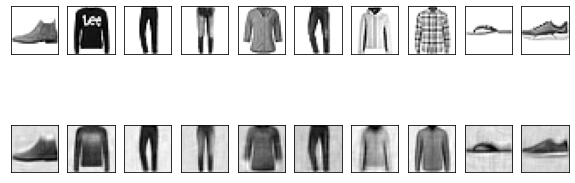

Train Epoch: 5 [0/60000 (0%)]	Train Loss: 0.012220
Train Epoch: 5 [6400/60000 (11%)]	Train Loss: 0.012850
Train Epoch: 5 [12800/60000 (21%)]	Train Loss: 0.010413
Train Epoch: 5 [19200/60000 (32%)]	Train Loss: 0.010297
Train Epoch: 5 [25600/60000 (43%)]	Train Loss: 0.009765
Train Epoch: 5 [32000/60000 (53%)]	Train Loss: 0.010637
Train Epoch: 5 [38400/60000 (64%)]	Train Loss: 0.010542
Train Epoch: 5 [44800/60000 (75%)]	Train Loss: 0.011707
Train Epoch: 5 [51200/60000 (85%)]	Train Loss: 0.010329
Train Epoch: 5 [57600/60000 (96%)]	Train Loss: 0.012075

[EPOCH: 5], 	Test Loss: 0.0003


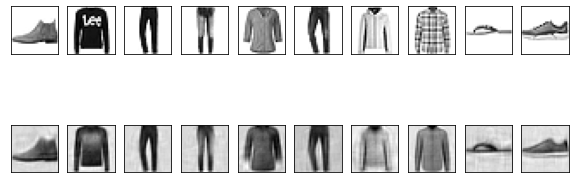

Train Epoch: 6 [0/60000 (0%)]	Train Loss: 0.012568
Train Epoch: 6 [6400/60000 (11%)]	Train Loss: 0.009645
Train Epoch: 6 [12800/60000 (21%)]	Train Loss: 0.012220
Train Epoch: 6 [19200/60000 (32%)]	Train Loss: 0.011725
Train Epoch: 6 [25600/60000 (43%)]	Train Loss: 0.012008
Train Epoch: 6 [32000/60000 (53%)]	Train Loss: 0.011805
Train Epoch: 6 [38400/60000 (64%)]	Train Loss: 0.009326
Train Epoch: 6 [44800/60000 (75%)]	Train Loss: 0.011938
Train Epoch: 6 [51200/60000 (85%)]	Train Loss: 0.010724
Train Epoch: 6 [57600/60000 (96%)]	Train Loss: 0.010410

[EPOCH: 6], 	Test Loss: 0.0003


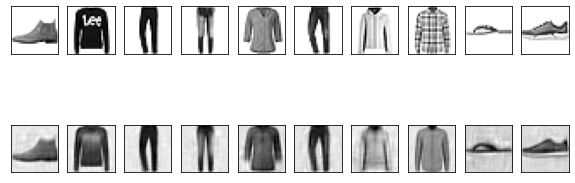

Train Epoch: 7 [0/60000 (0%)]	Train Loss: 0.009556
Train Epoch: 7 [6400/60000 (11%)]	Train Loss: 0.008211
Train Epoch: 7 [12800/60000 (21%)]	Train Loss: 0.015303
Train Epoch: 7 [19200/60000 (32%)]	Train Loss: 0.011028
Train Epoch: 7 [25600/60000 (43%)]	Train Loss: 0.011131
Train Epoch: 7 [32000/60000 (53%)]	Train Loss: 0.010261
Train Epoch: 7 [38400/60000 (64%)]	Train Loss: 0.007329
Train Epoch: 7 [44800/60000 (75%)]	Train Loss: 0.010010
Train Epoch: 7 [51200/60000 (85%)]	Train Loss: 0.010375
Train Epoch: 7 [57600/60000 (96%)]	Train Loss: 0.012309

[EPOCH: 7], 	Test Loss: 0.0003


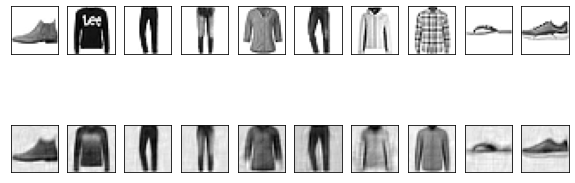

Train Epoch: 8 [0/60000 (0%)]	Train Loss: 0.007968
Train Epoch: 8 [6400/60000 (11%)]	Train Loss: 0.009734
Train Epoch: 8 [12800/60000 (21%)]	Train Loss: 0.010879
Train Epoch: 8 [19200/60000 (32%)]	Train Loss: 0.007314
Train Epoch: 8 [25600/60000 (43%)]	Train Loss: 0.010091
Train Epoch: 8 [32000/60000 (53%)]	Train Loss: 0.010800
Train Epoch: 8 [38400/60000 (64%)]	Train Loss: 0.009308
Train Epoch: 8 [44800/60000 (75%)]	Train Loss: 0.010109
Train Epoch: 8 [51200/60000 (85%)]	Train Loss: 0.012511
Train Epoch: 8 [57600/60000 (96%)]	Train Loss: 0.009507

[EPOCH: 8], 	Test Loss: 0.0003


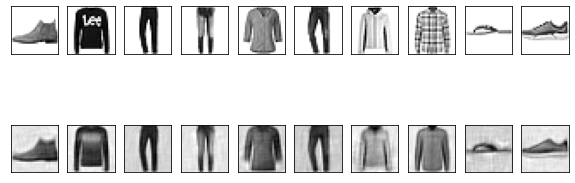

Train Epoch: 9 [0/60000 (0%)]	Train Loss: 0.010804
Train Epoch: 9 [6400/60000 (11%)]	Train Loss: 0.006912
Train Epoch: 9 [12800/60000 (21%)]	Train Loss: 0.009818
Train Epoch: 9 [19200/60000 (32%)]	Train Loss: 0.009985
Train Epoch: 9 [25600/60000 (43%)]	Train Loss: 0.010131
Train Epoch: 9 [32000/60000 (53%)]	Train Loss: 0.008542
Train Epoch: 9 [38400/60000 (64%)]	Train Loss: 0.009769
Train Epoch: 9 [44800/60000 (75%)]	Train Loss: 0.007090
Train Epoch: 9 [51200/60000 (85%)]	Train Loss: 0.010364
Train Epoch: 9 [57600/60000 (96%)]	Train Loss: 0.012344

[EPOCH: 9], 	Test Loss: 0.0003


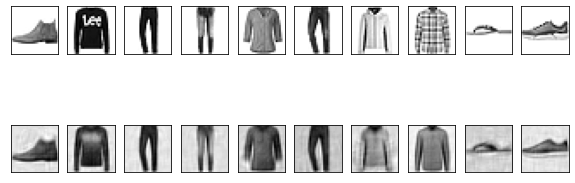

Train Epoch: 10 [0/60000 (0%)]	Train Loss: 0.011389
Train Epoch: 10 [6400/60000 (11%)]	Train Loss: 0.009037
Train Epoch: 10 [12800/60000 (21%)]	Train Loss: 0.008527
Train Epoch: 10 [19200/60000 (32%)]	Train Loss: 0.007326
Train Epoch: 10 [25600/60000 (43%)]	Train Loss: 0.009173
Train Epoch: 10 [32000/60000 (53%)]	Train Loss: 0.008417
Train Epoch: 10 [38400/60000 (64%)]	Train Loss: 0.010091
Train Epoch: 10 [44800/60000 (75%)]	Train Loss: 0.009709
Train Epoch: 10 [51200/60000 (85%)]	Train Loss: 0.009575
Train Epoch: 10 [57600/60000 (96%)]	Train Loss: 0.013164

[EPOCH: 10], 	Test Loss: 0.0003


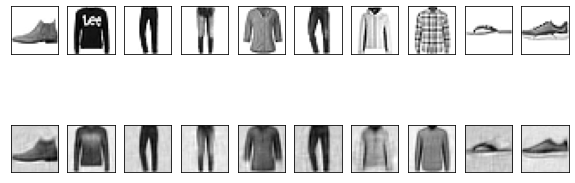

In [25]:
''' 10. AutoEncoder 학습 실행하며 Test set의 Reconstruction Error 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()